In [207]:
# Import packages
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import model and metrics
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor,VotingRegressor,BaggingRegressor,StackingRegressor,GradientBoostingRegressor,HistGradientBoostingRegressor

In [196]:
# Global tickers

tickers = [
  # 🌎 Stock Indices
  "^GSPC",      # S&P 500 (USA)
  "^DJI",       # Dow Jones Industrial Average (USA)
  "^IXIC",      # Nasdaq Composite (USA)
  "^BVSP",      # Bovespa (Brazil)
  "^MXX",       # IPC (Mexico)
  "^FTSE",      # FTSE 100 (UK)
  "^GDAXI",     # DAX (Germany)
  "^FCHI",      # CAC 40 (France)
  "^STOXX50E",  # Euro Stoxx 50 (Europe)
  "^N225",      # Nikkei 225 (Japan)
  "^HSI",       # Hang Seng Index (Hong Kong)
  "^NSEI",      # Nifty 50 (India)
  "^KS11",      # KOSPI (South Korea)
  "^TWII",      # TAIEX (Taiwan)
  "^AXJO",      # ASX 200 (Australia)

  # 💱 Currencies (Forex Pairs)
  "DX-Y.NYB",   # US Dollar Index (ICE Futures)
  "EURUSD=X",   # Euro / US Dollar
  "JPY=X",      # US Dollar / Japanese Yen
  "GBPUSD=X",   # British Pound / US Dollar
  "AUDUSD=X",   # Australian Dollar / US Dollar
  "USDCAD=X",   # US Dollar / Canadian Dollar
  "USDCHF=X",   # US Dollar / Swiss Franc
  "USDHKD=X",   # US Dollar / Hong Kong Dollar
  "USDINR=X",   # US Dollar / Indian Rupee
  "USDKRW=X",   # US Dollar / South Korean Won

  # 🛢 Commodities (Futures)
  "GC=F",       # Gold
  "SI=F",       # Silver
  "CL=F",       # Crude Oil WTI
  "BZ=F",       # Brent Crude Oil
  "NG=F",       # Natural Gas
  "HG=F",       # Copper
  "PL=F",       # Platinum
  "PA=F",       # Palladium

  # 🏛 Bonds & Interest Rates
  "^TNX",       # 10-Year US Treasury Yield
  "^FVX",       # 5-Year US Treasury Yield
  "^TYX"        # 30-Year US Treasury Yield
]


In [197]:
# Import data
df = yf.download(tickers=tickers,period='10y').iloc[:,:len(tickers)]


/tmp/ipykernel_13183/4041643037.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=tickers,period='10y').iloc[:,:len(tickers)]
[*********************100%***********************]  36 of 36 completed


In [198]:
# Preprocessing 

# Change column names
new_cols = []
for i in df.columns:
    new_cols.append(i[1])

df.columns = new_cols
df = df.dropna()

# Transform columns to % change w.r.t. prev

df = df.pct_change()*100
df

,AUDUSD=X,BZ=F,CL=F,DX-Y.NYB,EURUSD=X,GBPUSD=X,GC=F,HG=F,JPY=X,NG=F,...,^HSI,^IXIC,^KS11,^MXX,^N225,^NSEI,^STOXX50E,^TNX,^TWII,^TYX
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-04,-0.327418,0.949114,1.261907,0.451331,-0.118318,-0.233857,0.119325,0.745471,-0.076589,2.328971,...,-0.021714,-0.192167,0.970879,0.610261,-0.135049,-0.306090,-0.442588,2.837203,-0.158954,0.908774
2015-08-05,1.379363,-0.800163,-1.289900,0.030633,-0.611964,-0.137014,-0.458421,-0.507403,0.265442,-0.497864,...,0.442680,0.673583,0.087280,-0.532054,0.456625,0.599394,1.587041,2.578015,0.369050,1.939730
2015-08-06,-0.316178,-0.141157,-1.085275,-0.132704,0.129752,0.237223,0.414479,-0.212489,0.366932,0.536092,...,-0.566533,-1.624533,-0.811425,-0.036474,0.244391,0.241600,-0.225200,-1.499115,-1.085313,-1.223242
2015-08-07,-0.102836,-1.837641,-1.768923,-0.275993,0.219633,-0.587996,0.357735,-0.276832,0.003205,-0.533234,...,0.726931,-0.255118,-0.151993,-0.131515,0.290940,-0.280030,-0.836041,-2.641003,-0.086035,-2.717578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-28,-0.366762,2.337812,2.378753,1.034308,0.005871,-0.512095,-0.746848,-2.923578,0.549640,-3.922829,...,0.684492,0.332853,0.421457,-0.417950,-1.104685,-0.628496,-0.272415,0.775192,0.208007,0.710090
2025-07-29,-0.745047,3.526558,3.747564,0.253395,-1.361462,-0.599866,0.432136,0.151923,0.450570,3.112456,...,-0.147412,-0.379114,0.655863,1.291480,-0.789591,0.568047,0.779756,-2.036203,-0.903178,-1.873497
2025-07-30,-0.165438,1.006752,1.141455,1.041349,-0.395043,-0.049414,-0.830470,-0.597836,-0.024921,-1.168452,...,-1.361516,0.148737,0.739804,-0.734908,-0.048806,0.136784,0.259890,1.062356,1.121483,0.821186


In [199]:
# Correlation analysis
global_params = []
for i in df.corr().loc[:,'^NSEI'].items():
    if (i[1]>0.1) or (i[1]<-0.1):
        global_params.append(i[0])
    else:
        pass

# Select features from correlationn analysis
df = df[global_params]
df = df.dropna()
df

,AUDUSD=X,BZ=F,GBPUSD=X,HG=F,PA=F,PL=F,SI=F,USDCAD=X,USDINR=X,USDKRW=X,...,^HSI,^IXIC,^KS11,^MXX,^N225,^NSEI,^STOXX50E,^TNX,^TWII,^TYX
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-04,-0.327418,0.949114,-0.233857,0.745471,-0.763238,-0.889714,0.234227,0.282746,0.225072,0.348600,...,-0.021714,-0.192167,0.970879,0.610261,-0.135049,-0.306090,-0.442588,2.837203,-0.158954,0.908774
2015-08-05,1.379363,-0.800163,-0.137014,-0.507403,-0.936294,-0.782881,-0.027496,0.257642,-0.475641,-0.134333,...,0.442680,0.673583,0.087280,-0.532054,0.456625,0.599394,1.587041,2.578015,0.369050,1.939730
2015-08-06,-0.316178,-0.141157,0.237223,-0.212489,1.147677,0.536557,0.852472,-0.174350,-0.192734,0.412117,...,-0.566533,-1.624533,-0.811425,-0.036474,0.244391,0.241600,-0.225200,-1.499115,-1.085313,-1.223242
2015-08-07,-0.102836,-1.837641,-0.587996,-0.276832,-0.483892,0.648808,0.995228,-0.423728,0.058092,-0.888263,...,0.726931,-0.255118,-0.151993,-0.131515,0.290940,-0.280030,-0.836041,-2.641003,-0.086035,-2.717578
2015-08-10,0.769806,3.702940,-0.130149,2.818705,1.559354,2.817637,3.192492,0.242506,0.000000,0.000000,...,-0.127692,1.155136,-0.351200,1.022133,0.405938,-0.455363,1.020944,2.896550,0.290797,2.652053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-28,-0.366762,2.337812,-0.512095,-2.923578,2.983752,-0.234478,-0.369426,0.450860,0.087707,0.785716,...,0.684492,0.332853,0.421457,-0.417950,-1.104685,-0.628496,-0.272415,0.775192,0.208007,0.710090
2025-07-29,-0.745047,3.526558,-0.599866,0.151923,-0.960566,-0.007120,0.152524,0.234998,0.313850,0.398473,...,-0.147412,-0.379114,0.655863,1.291480,-0.789591,0.568047,0.779756,-2.036203,-0.903178,-1.873497
2025-07-30,-0.165438,1.006752,-0.049414,-0.597836,-1.025075,-3.084049,-1.360145,0.288330,0.329116,0.041054,...,-1.361516,0.148737,0.739804,-0.734908,-0.048806,0.136784,0.259890,1.062356,1.121483,0.821186


In [200]:
# train test split with n % test data

test_per = .2  # n% test data

test_size = int(np.ceil(df.shape[0]*test_per))
train_size = df.shape[0]-test_size

train_df = df.iloc[:train_size,:]
test_df = df.iloc[train_size:,:]

X_train = train_df.drop('^NSEI',axis=1)
X_test = test_df.drop('^NSEI',axis=1)
y_train = train_df['^NSEI']
y_test = test_df['^NSEI']

In [201]:
# Metrics list
metrics = []

In [204]:
# Modelling

# Regression Models
regression_models = {'Linear Regression' : LinearRegression(),
                     'Random Forest regressor' : RandomForestRegressor(),
                     'Decision Tree Regressor' : DecisionTreeRegressor(),
                     'Light GBM Regressor' : LGBMRegressor(),
                     'KNeighbors Regressor' : KNeighborsRegressor(),
                     'Support Vector regressor' : SVR(),
                     'AdaBoost Regressor' : AdaBoostRegressor(),
                     'Bagging Regressor' : BaggingRegressor(),
                    #  'Stacking Regressor' : StackingRegressor(),
                     'Gradient Boosting Regressor' : GradientBoostingRegressor(),
                     'Hist Gradient Boosting Regressor' : HistGradientBoostingRegressor()}

for i in regression_models:
    print('Model : ',i)
    if i!= 'Linear Regression':
        dict_ = {} # Metrics dictionary
        model = regression_models[i]
        model.fit(X_train,y_train)
        print('R2 score for train data : ', model.score(X_train,y_train))
        print('R2 score for test data : ', model.score(X_test,y_test))

        y_pred = model.predict(X_test)

        rmse = root_mean_squared_error(y_test,y_pred)
        print('Root Mean Squared Error : ',rmse)

        dict_['Model'] = i
        dict_['R2_Train'] = model.score(X_train,y_train)
        dict_['R2_Test'] = model.score(X_test,y_test)
        dict_['RMSE'] = rmse
    
        

    else:
        dict_ = {} # Metrics dictionary
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)


        # Modeling
        model = regression_models[i]
        model.fit(X_train_scaled,y_train)
        print('R2 score for train data : ', model.score(X_train_scaled,y_train))
        print('R2 score for test data : ', model.score(X_test_scaled,y_test))

        y_pred = model.predict(X_test_scaled)

        rmse = root_mean_squared_error(y_test,y_pred)
        print('Root Mean Squared Error : ',rmse)

        dict_['Model'] = i
        dict_['R2_Train'] = model.score(X_train,y_train)
        dict_['R2_Test'] = model.score(X_test,y_test)
        dict_['RMSE'] = rmse

    print('-'*75)

    metrics.append(dict_)

Model :  Linear Regression
R2 score for train data :  0.41327616212704066
R2 score for test data :  0.08010348766421482
Root Mean Squared Error :  0.935829205225421
---------------------------------------------------------------------------
Model :  Random Forest regressor
R2 score for train data :  0.9090887352345829
R2 score for test data :  0.15690815510670475
Root Mean Squared Error :  0.8959103474101185
---------------------------------------------------------------------------
Model :  Decision Tree Regressor
R2 score for train data :  1.0
R2 score for test data :  -0.6149075576350749
Root Mean Squared Error :  1.2399407749203086
---------------------------------------------------------------------------
Model :  Light GBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train se

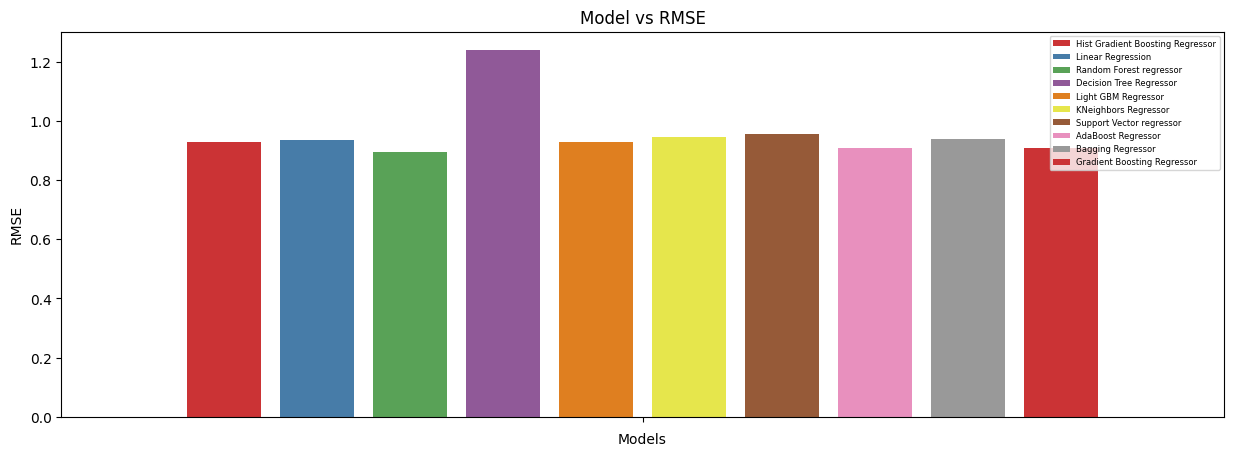

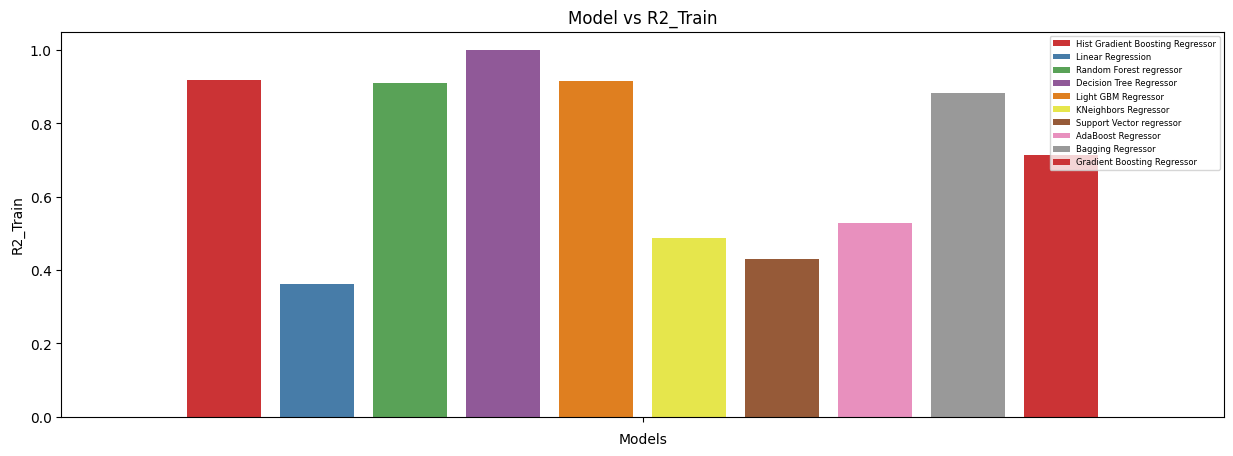

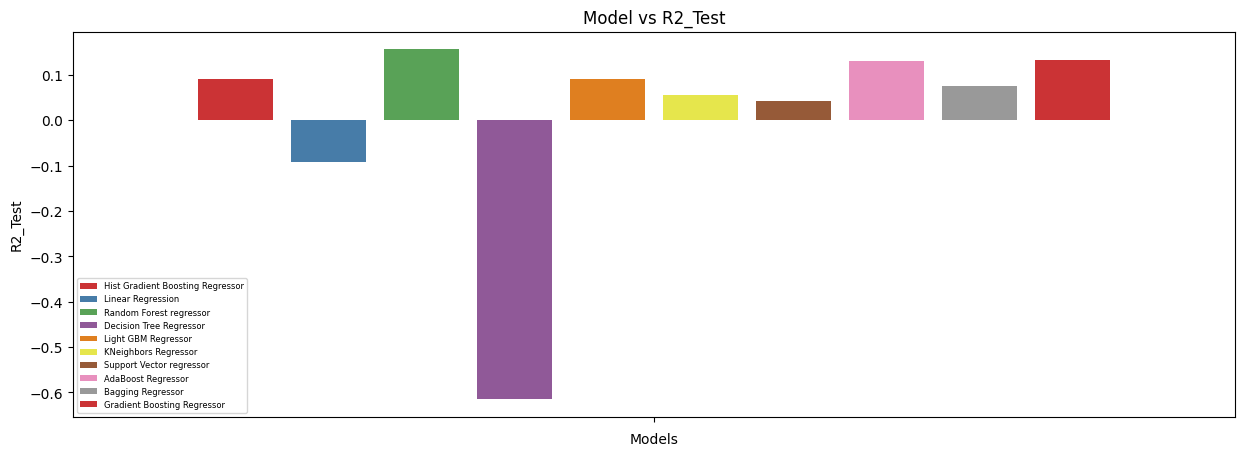

                               Model  R2_Train   R2_Test      RMSE
0   Hist Gradient Boosting Regressor  0.917802  0.091978  0.929770
1                  Linear Regression  0.362801 -0.091941  0.935829
2            Random Forest regressor  0.909089  0.156908  0.895910
3            Decision Tree Regressor  1.000000 -0.614908  1.239941
4                Light GBM Regressor  0.915541  0.090246  0.930656
5               KNeighbors Regressor  0.488298  0.056955  0.947531
6           Support Vector regressor  0.429513  0.041994  0.955017
7                 AdaBoost Regressor  0.528814  0.130299  0.909939
8                  Bagging Regressor  0.881965  0.076725  0.937546
9        Gradient Boosting Regressor  0.713547  0.133498  0.908263
10  Hist Gradient Boosting Regressor  0.917802  0.091978  0.929770


In [250]:
# Metrics visualization

eval_metrics = pd.DataFrame(metrics)


for n,i in enumerate(['RMSE','R2_Train','R2_Test']) :
    plt.figure(figsize=(15,5))
    X = eval_metrics['Model']
    y = eval_metrics[i]

    sns.barplot(data=eval_metrics,hue='Model',y = i, palette='Set1',gap=0.2)
    plt.xticks(rotation=90,fontsize = 8)
    plt.title(f'Model vs {i}')
    plt.legend(fontsize=6)
    plt.xlabel('Models')
    plt.show()

print(eval_metrics)

# Recommondation
### Random Forest Regressor is recommonded.